https://collegescorecard.ed.gov/data

Can we predict whether a college is public or private based on its enrollment size, tuition, and financial aid data?

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [3]:
tuition = pd.read_csv(r"C:\Users\kdiza\Downloads\Most-Recent-Cohorts-Institution_05192025\Most-Recent-Cohorts-Institution_05192025.csv", na_values=['?'])
tuition.info()

C:\Users\kdiza\AppData\Local\Temp\ipykernel_31492\3929638941.py:1: DtypeWarning: Columns (9,1407,1408,1431,1432,1532,1537,1538,1539,1540,1542,1546,1589,1601,1602,1606,1608,1611,1614,1615,1616,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,1653,1679,1690,1692,1697,1700,1702,1725,1726,1727,1728,1729,1743,1815,1816,1817,1818,1823,1824,1830,1831,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1909,1910,1911,1912,1913,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1983,1984,2376,2377,2403,2404,2495,2496,2497,2498,2499,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509,2510,2511,2512,2513,2514,2515,2516,2517,2518,2519,2520,2521,2522,2523,2524,2525,2526,2527,2528,2529,2530,2958,3215,3231,3235,3236) have mixed types. Specify dtype option on import or set low_memory=False.
  tuition = pd.read_csv(r"C:\Users\kdiza\Downloads\Most-Recent-Cohorts-Institution_05192025\Most-Recent-Cohorts-I

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6429 entries, 0 to 6428
Columns: 3306 entries, UNITID to SCORECARD_SECTOR
dtypes: float64(920), int64(14), object(2372)
memory usage: 162.2+ MB


In [4]:
out_path = "ipeds_public_private_subset.csv"

wanted = [
    "UNITID",          # unique ID
    "INSTNM",          # institution name
    "CONTROL",         # target: 1=Public, 2=Private nonprofit, 3=Private for-profit
    "UGDS",            # undergrad enrollment
    "TUITIONFEE_IN",   # in-state tuition
    "TUITIONFEE_OUT",  # out-of-state tuition
    "PCTPELL",         # % students receiving Pell Grants
    "PCTFLOAN"         # % students receiving federal loans
]

# LOAD
df = tuition

# SELECT ONLY AVAILABLE COLUMNS
have = [c for c in wanted if c in df.columns]
missing = [c for c in wanted if c not in df.columns]
print("Keeping:", have)
if missing:
    print("Missing (not in file):", missing)

df_small = df[have].copy()

# MAKE BINARY TARGET: Public vs Private 
# CONTROL: 1=Public, 2=Private nonprofit, 3=Private for-profit
df_small["Target"] = df_small["CONTROL"].replace({1: "Public", 2: "Private", 3: "Private"})

# DROP ROWS WITH MISSING CRITICAL FIELDS 
crit = ["UGDS", "TUITIONFEE_IN", "TUITIONFEE_OUT", "PCTPELL", "PCTFLOAN", "Target"]
present_crit = [c for c in crit if c in df_small.columns]
df_small = df_small.dropna(subset=present_crit)

# CAST TYPES (helps modeling later)
num_cols = [c for c in ["UGDS", "TUITIONFEE_IN", "TUITIONFEE_OUT", "PCTPELL", "PCTFLOAN"] if c in df_small.columns]
for c in num_cols:
    df_small[c] = pd.to_numeric(df_small[c], errors="coerce")

# SAVE
df_small.to_csv(out_path, index=False)
print("Saved:", out_path, "| Shape:", df_small.shape)

Keeping: ['UNITID', 'INSTNM', 'CONTROL', 'UGDS', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'PCTPELL', 'PCTFLOAN']
Saved: ipeds_public_private_subset.csv | Shape: (3389, 9)


In [5]:
tuition_clean = pd.read_csv("https://raw.githubusercontent.com/izaan-khudadad/Data-Mining/refs/heads/main/ipeds_public_private_subset.csv", na_values=['?'])
tuition_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3389 entries, 0 to 3388
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UNITID          3389 non-null   int64  
 1   INSTNM          3389 non-null   object 
 2   CONTROL         3389 non-null   int64  
 3   UGDS            3389 non-null   float64
 4   TUITIONFEE_IN   3389 non-null   float64
 5   TUITIONFEE_OUT  3389 non-null   float64
 6   PCTPELL         3389 non-null   float64
 7   PCTFLOAN        3389 non-null   float64
 8   Target          3389 non-null   object 
dtypes: float64(5), int64(2), object(2)
memory usage: 238.4+ KB


In [6]:
tuition_clean.isnull().sum()

UNITID            0
INSTNM            0
CONTROL           0
UGDS              0
TUITIONFEE_IN     0
TUITIONFEE_OUT    0
PCTPELL           0
PCTFLOAN          0
Target            0
dtype: int64

In [7]:
columns = tuition_clean.columns
for col in columns:
    print('****',col,'****')
    print(tuition_clean[col].describe())

**** UNITID ****
count      3389.000000
mean     229820.452346
std      112856.016707
min      100654.000000
25%      156231.000000
50%      197993.000000
75%      234085.000000
max      499538.000000
Name: UNITID, dtype: float64
**** INSTNM ****
count                   3389
unique                  3355
top       Lincoln University
freq                       3
Name: INSTNM, dtype: object
**** CONTROL ****
count    3389.000000
mean        1.653290
std         0.684543
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: CONTROL, dtype: float64
**** UGDS ****
count      3389.000000
mean       3960.246680
std        7545.647909
min           4.000000
25%         499.000000
50%        1495.000000
75%        4100.000000
max      156755.000000
Name: UGDS, dtype: float64
**** TUITIONFEE_IN ****
count     3389.000000
mean     17686.966657
std      16159.849271
min        600.000000
25%       5542.000000
50%      11790.000000
75%      24

In [8]:
X = tuition_clean[["UGDS", "TUITIONFEE_IN", "TUITIONFEE_OUT", "PCTPELL", "PCTFLOAN"]]
y = tuition_clean["Target"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [11]:
y_pred = log_reg.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9572271386430679

Confusion Matrix:
 [[347  14]
 [ 15 302]]

Classification Report:
               precision    recall  f1-score   support

     Private       0.96      0.96      0.96       361
      Public       0.96      0.95      0.95       317

    accuracy                           0.96       678
   macro avg       0.96      0.96      0.96       678
weighted avg       0.96      0.96      0.96       678



<Figure size 500x400 with 0 Axes>

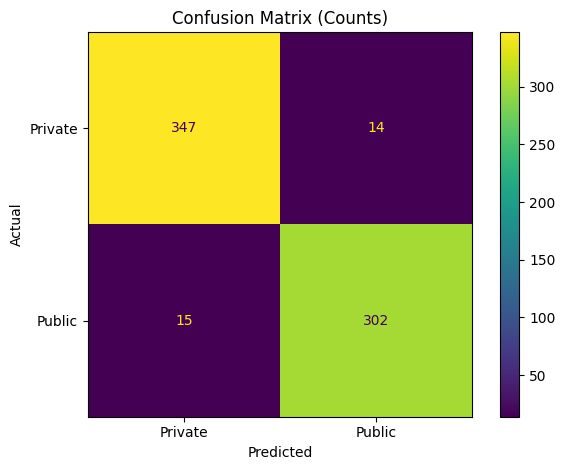

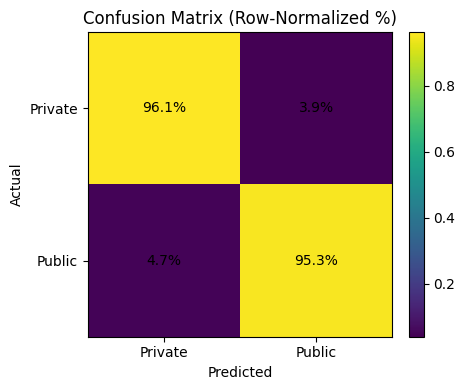

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

# 1) Compute CM
labels = sorted(y_test.unique())   # e.g., ["Private","Public"] (adjust if you prefer another order)
cm = confusion_matrix(y_test, y_pred, labels=labels)

# 2) Plot RAW counts
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(5,4))
disp.plot(values_format='d', cmap=None, colorbar=True)  # no specific colors (default)
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 3) Plot NORMALIZED (row-wise %) 
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5,4))
im = plt.imshow(cm_norm, interpolation='nearest')
plt.title("Confusion Matrix (Row-Normalized %)")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(np.arange(len(labels)), labels, rotation=0)
plt.yticks(np.arange(len(labels)), labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# annotate with percentages
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        txt = f"{cm_norm[i, j]*100:.1f}%"
        plt.text(j, i, txt, ha='center', va='center')

plt.tight_layout()
plt.show()


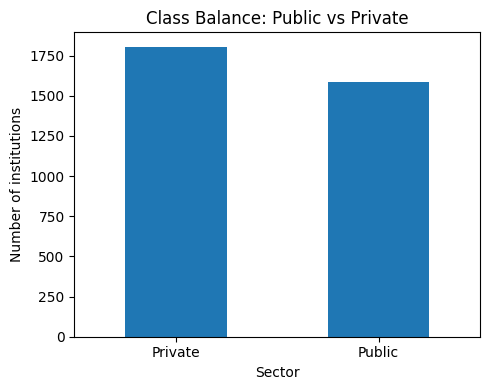

In [ ]:
counts = tuition_clean["Target"].value_counts().sort_index()

plt.figure(figsize=(5,4))
counts.plot(kind="bar")
plt.title("Class Balance: Public vs Private")
plt.xlabel("Sector")
plt.ylabel("Number of institutions")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

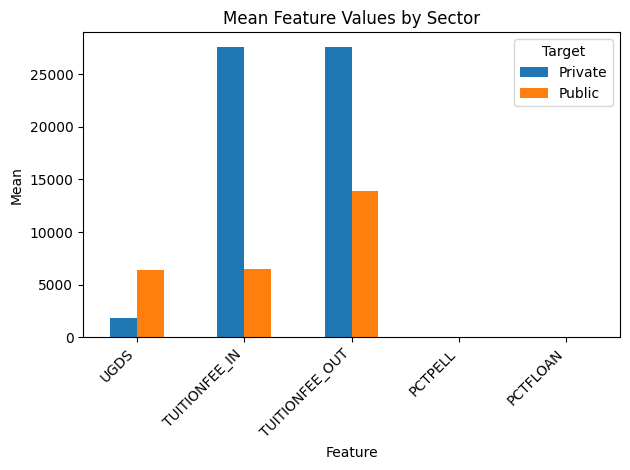

In [ ]:
num_cols = [c for c in ["UGDS","TUITIONFEE_IN","TUITIONFEE_OUT","PCTPELL","PCTFLOAN"]
            if c in tuition_clean.columns]

grp = tuition_clean.groupby("Target")[num_cols].mean().T  # rows=features, cols=sectors

plt.figure(figsize=(8,5))
grp.plot(kind="bar")
plt.title("Mean Feature Values by Sector")
plt.xlabel("Feature")
plt.ylabel("Mean")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

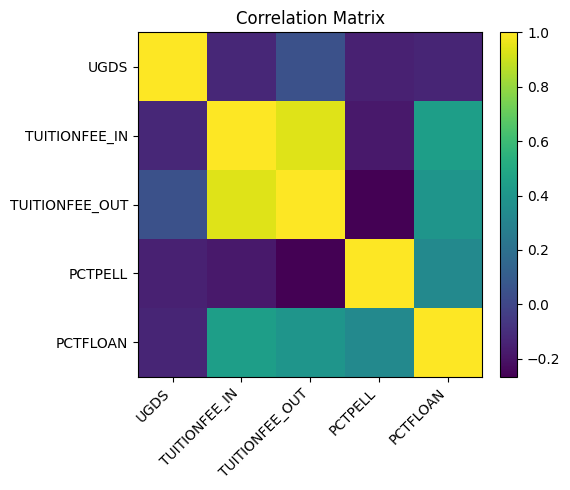

In [ ]:
num_df = tuition_clean[num_cols].copy()
corr = num_df.corr(numeric_only=True)

plt.figure(figsize=(6,5))
im = plt.imshow(corr.values, interpolation="nearest")
plt.title("Correlation Matrix")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.tight_layout()
plt.show()

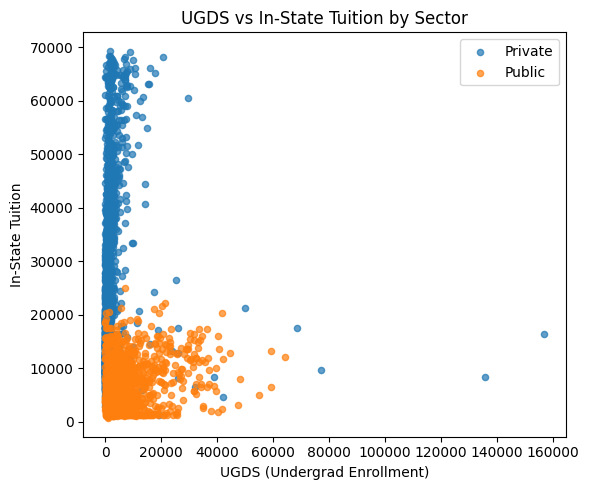

In [ ]:
plt.figure(figsize=(6,5))
for label, sub in tuition_clean.groupby("Target"):
    plt.scatter(sub["UGDS"], sub["TUITIONFEE_IN"], label=label, alpha=0.7, s=20)

plt.title("UGDS vs In-State Tuition by Sector")
plt.xlabel("UGDS (Undergrad Enrollment)")
plt.ylabel("In-State Tuition")
plt.legend()
plt.tight_layout()
plt.show()